# Prediction of the number of migrations between two districts per year OLS

In [1]:
import math
import lxml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/celsadiaz/.pyenv/versions/3.6.2/envs/pop_dyn/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def normalize_features(feature_vector, columns_to_scale):
    for feature in columns_to_scale:
        scaler = StandardScaler()#with_mean=0, with_std=1)
        feature_vector[feature] = scaler.fit_transform(feature_vector[feature])
    return feature_vector

def split_train_test_by_quartiles(feature_vector, feature_columns, target_column, n_splits_dist, labels, train_size):
    X = feature_vector.loc[:, (feature_columns)]
    y = feature_vector.loc[:, target_column]
    
    # extract quartiles from continuous target to equally split between train/test
    label_list = pd.qcut(feature_vector[target_column], n_splits_dist, labels=labels).tolist()
    
    # Split train/test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=32, 
                                                                  stratify=label_list)
    return X_train, X_test, y_train, y_test

In [3]:
f_vector = pd.read_csv("../feature_extraction/data/feature_vector_complete.csv")

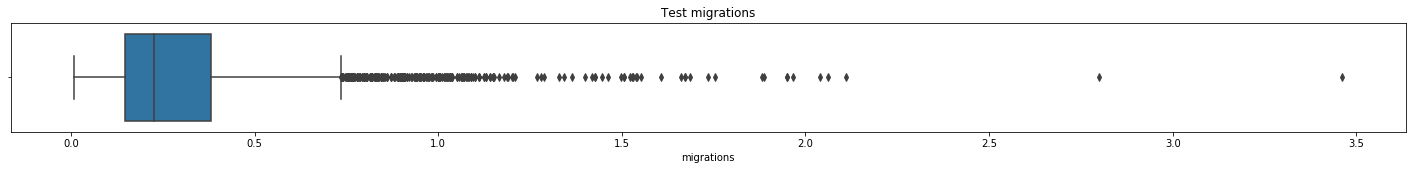

In [4]:
_=plt.figure(figsize=(25, 2))
_=plt.title("Test migrations")
_=sns.boxplot(f_vector['migrations'])

In [5]:
f_vector[f_vector['migrations'] > 2.5]

,migrations,destination,origin,year,n_inhabitants_or,net_income_or,euribor,density_or,rev_1000_inh_or,var_review_or,...,rev_1000_inh_diff,var_review_diff,unemployed_diff,eldery_perc_diff,d_inner_n_diff,d_outer_n_diff,var_sale_m2_diff,var_rent_m2_diff,n_tran_rs_diff,n_tran_new_rs_diff
316,3.461478,Villa de Vallecas,Puente de Vallecas,2007,461817.0,23405.03,4.064,152.05,0.0,0.0,...,0.0,0.0,-0.076640,-5.222267,3.178951,-0.369562,0.113030,1.609018,16.677943,16.677943
1076,2.799199,Villa de Vallecas,Puente de Vallecas,2009,469133.0,23405.03,2.622,152.05,0.0,0.0,...,0.0,0.0,-0.111384,-5.991983,3.770764,-0.435502,5.080003,2.850579,18.237017,18.237017


In [6]:
# Remove the two outliers with values higher than 50
f_vector = f_vector[f_vector['migrations'] < 2.5] 

In [7]:
f_vector.columns

Index(['migrations', 'destination', 'origin', 'year', 'n_inhabitants_or',
       'net_income_or', 'euribor', 'density_or', 'rev_1000_inh_or',
       'var_review_or', 'unemployed_or', 'eldery_perc_or', 'd_inner_n_or',
       'd_outer_n_or', 'var_n_biz', 'var_sale_m2_or', 'var_rent_m2_or',
       'n_tran_rs_or', 'n_tran_new_rs_or', 'mortage_executions',
       'n_inhabitants_de', 'net_income_de', 'density_de', 'rev_1000_inh_de',
       'var_review_de', 'unemployed_de', 'eldery_perc_de', 'd_inner_n_de',
       'd_outer_n_de', 'var_sale_m2_de', 'var_rent_m2_de', 'n_tran_rs_de',
       'n_tran_new_rs_de', 'net_income_diff', 'density_diff',
       'rev_1000_inh_diff', 'var_review_diff', 'unemployed_diff',
       'eldery_perc_diff', 'd_inner_n_diff', 'd_outer_n_diff',
       'var_sale_m2_diff', 'var_rent_m2_diff', 'n_tran_rs_diff',
       'n_tran_new_rs_diff'],
      dtype='object')

In [8]:
f_vector.loc[f_vector[f_vector['year'] <= 2008].index, 'period'] = 0
f_vector.loc[f_vector[(f_vector['year'] > 2008) & (f_vector['year'] <= 2011)].index, 'period'] = 2
f_vector.loc[f_vector[f_vector['year'] > 2011].index, 'period'] = 1

In [9]:
feature_columns = ['net_income_or', 'density_or', 'rev_1000_inh_or', 'unemployed_or', 'eldery_perc_or', 
                   'var_sale_m2_or', 'var_rent_m2_or', 'n_tran_new_rs_or', 'var_review_or',
                   'n_tran_new_rs_or', "mortage_executions", 'var_n_biz', 'period' ,
                   'net_income_de', 'rev_1000_inh_de', 'var_review_de', 'unemployed_de','eldery_perc_de', 
                   "var_sale_m2_de", "var_rent_m2_de", "n_tran_new_rs_de", "density_de",'year']
target_column = "migrations"
n_splits_dist = 5
labels = ["q1","q2","q3","q4","q5"]
train_size = 0.9
alpha = 0.05

### Build train/test data sets

In [10]:
#feature_vector = normalize_features(f_vector, feature_columns)
#feature_vector['period'] = feature_vector['period'].astype(int)

In [11]:
#feature_vector[feature_vector['period']==1].head()

In [12]:
#f_vector.period.unique()

In [13]:
# Scale features
feature_vector = normalize_features(f_vector, feature_columns)
feature_vector['period'] = feature_vector['period'].astype(int)
feature_vector.loc[feature_vector[feature_vector['period']==1].index, 'period'] = 2
feature_vector.loc[feature_vector[feature_vector['period']==0].index, 'period'] = 1
feature_vector.loc[feature_vector[feature_vector['period']==-1].index, 'period'] = 0

# Split data set: train/test X/Y
info_cols = ["origin","destination","year","migrations"]
info = feature_vector.loc[:,(info_cols)]

X_train, X_test, y_train, y_test = split_train_test_by_quartiles(feature_vector, feature_columns, 
                                                                 target_column, n_splits_dist, labels, train_size)

In [14]:
X_train.shape

(3418, 23)

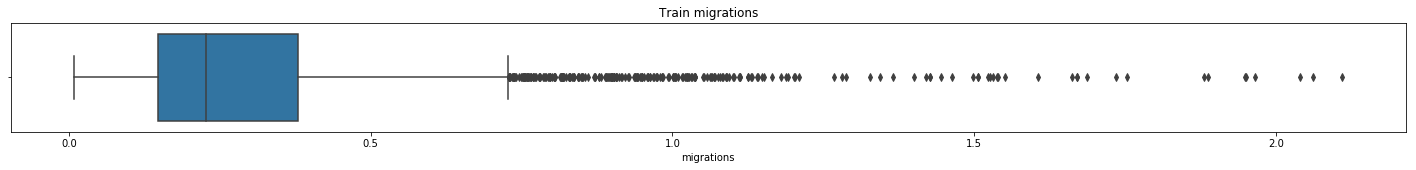

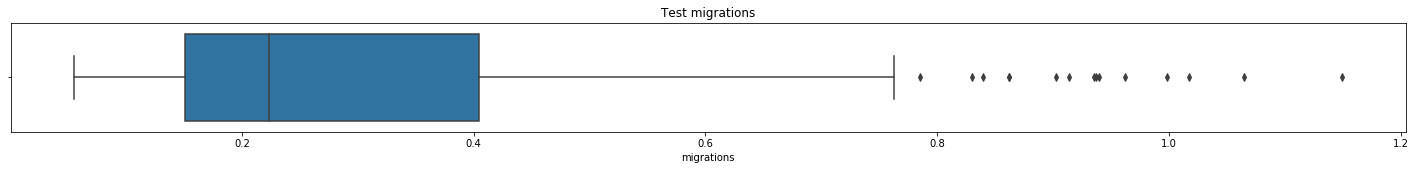

In [15]:
# Check if both samples have a similar distribution
_=plt.figure(figsize=(25, 2))
_=plt.title("Train migrations")
_=sns.boxplot(y_train)
_=plt.figure(figsize=(25, 2))
_=plt.title("Test migrations")
_=sns.boxplot(y_test)

## Model considering as feature inner/outer degree from previous year

### Train Linear Regression & Identify features with higher impact

In [16]:
# Add baseline
X_train_ = sm.add_constant(X_train.as_matrix())
X_test_ = sm.add_constant(X_test.as_matrix())

# Train linear regression and predict migrations
mod = sm.OLS(exog =X_train_, endog=np.array(y_train.astype(float))).fit()
y_pred = mod.predict(np.array(X_test_).astype(float))
summary = mod.summary(xname=feature_columns)

In [17]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     23.52
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           2.58e-88
Time:                        00:47:03   Log-Likelihood:                 58.248
No. Observations:                3418   AIC:                            -70.50
Df Residuals:                    3395   BIC:                             70.65
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
net_income_or          0.2901      0.014     20.419      0.000       0.262       0.318
density_or             0.0149      0.008      1.755      0.079      -0.002       0.032
rev_1000_inh_or        0.0711      0.006     12.664      0.000       0.060       0.082
unemployed_or          0.0146      0.004      3.252      0.001       0.006       0.023
eldery_perc_or         0.0130      0.011      1.164      0.245      -0.009       0.035
var_sale_m2_or        -0.0198      0.006     -3.252      0.001      -0.032      -0.008
var_rent_m2_or        -0.0021      0.007     -0.301      0.763      -0.016       0.012
n_tran_new_rs_or      -0.0008      0.007     -0.118      0.906      -0.014       0.013
var_review_or         -0.0013      0.002     -0.579      0.563      -0.006       0.003
n_tran_new_rs_or       0.0019      0.004      0.456      0.648      -0.006       0.010
mortage_executions    -0.0013      0.002     -0.579      0.563      -0.006       0.003
var_n_biz              0.0133      0.012      1.095      0.274      -0.011       0.037
period                 0.0294      0.014      2.072      0.038       0.002       0.057
net_income_de          0.0208      0.012      1.678      0.093      -0.004       0.045
rev_1000_inh_de        0.0139      0.008      1.634      0.102      -0.003       0.030
var_review_de         -0.0049      0.005     -1.037      0.300      -0.014       0.004
unemployed_de          0.0001      0.004      0.033      0.974      -0.008       0.009
eldery_perc_de         0.0242      0.011      2.190      0.029       0.003       0.046
var_sale_m2_de        -0.0323      0.006     -5.350      0.000      -0.044      -0.020
var_rent_m2_de        -0.0075      0.007     -1.051      0.293      -0.021       0.006
n_tran_new_rs_de       0.0100      0.007      1.428      0.153      -0.004       0.024
density_de             0.0439      0.004     10.031      0.000       0.035       0.052
year                   0.0446      0.006      7.954      0.000       0.034       0.056
==============================================================================
Omnibus:                     1870.057   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15277.881
Skew:                           2.511   Prob(JB):                         0.00
Kurtosis:                      12.059   Cond. No.                     2.48e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.58e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
pd.read_html(summary.tables[1].as_html(), header=0, 
             index_col='Unnamed: 0')[0].to_csv("../feature_extraction/data/results_gls.csv",
                                              index=True, encoding='utf-8')

In [19]:
summary = pd.read_csv("../feature_extraction/data/results_gls.csv").rename(columns={'Unnamed: 0':'features'})
summary = summary.sort_values(by="P>|t|", ascending=False)
summary = summary.rename(columns={'P>|t|':'P-value'})

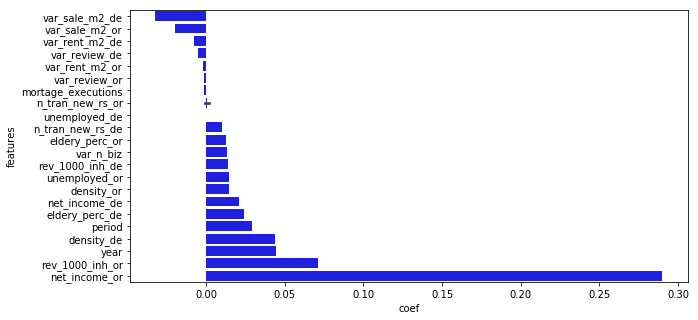

In [20]:
significant_factors = summary.copy()
significant_factors = significant_factors.sort_values(by="coef")
plt.figure(figsize=(10, 5))
sns.barplot(y="features",x="coef",data=significant_factors, color="blue")

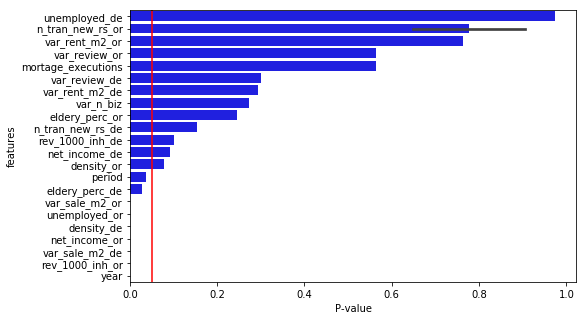

In [21]:
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="P-value",data=summary, color="blue")
plt.axvline(x=alpha, color="red")

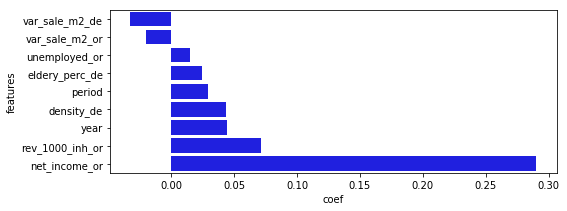

In [22]:
significant_factors = summary[summary["P-value"] < alpha]
significant_factors = significant_factors.sort_values(by="coef")
plt.figure(figsize=(8, 3))
sns.barplot(y="features",x="coef",data=significant_factors, color="blue")

### Evaluate performance of the model

In [23]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test, y_pred))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test, y_pred)))

The RMSE in the test data set is: 0.20
 The r2 score in the test data set is: 0.08


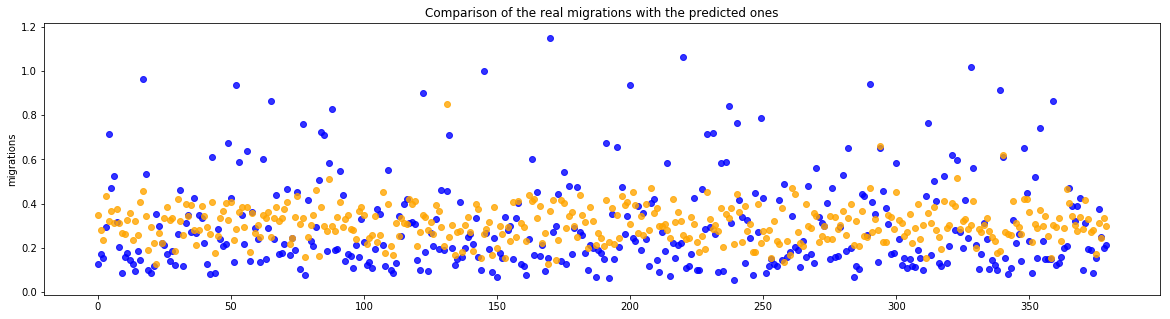

In [24]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test)), y=y_test, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred)), y=y_pred, fit_reg=False, color="orange")

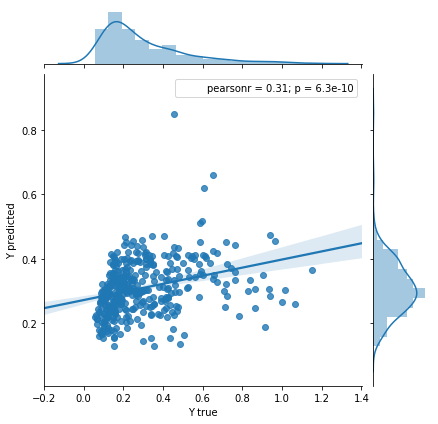

In [25]:
_=sns.jointplot(x=y_test, y=y_pred, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

## Compare factors correlation with the internal migrations per period (pre, during, after crisis)

### Linear model until the economical crisis 2008

In [26]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_b = feature_vector[feature_vector['period']==0]
feature_columns_ = [x for x in feature_columns if x not in ['period', 'year', 'rev_1000_inh_or','var_review_or',
                                                            'rev_1000_inh_de','var_review_de']]

# Split data set: train/test X/Y
info_cols = ["origin","destination","year","migrations"]
info_b = feature_vector_b.loc[:,(info_cols)]

X_train_b, X_test_b, y_train_b, y_test_b = split_train_test_by_quartiles(feature_vector_b, feature_columns_, 
                                                                 target_column, n_splits_dist, labels, train_size)

In [27]:
# Add baseline
X_train_b_ = sm.add_constant(X_train_b.as_matrix())
X_test_b_ = sm.add_constant(X_test_b.as_matrix())

# Train linear regression and predict migrations
mod_b = sm.OLS(exog =X_train_b_, endog=np.array(y_train_b.astype(float))).fit()
y_pred_b = mod_b.predict(np.array(X_test_b_).astype(float))
summary_b = mod_b.summary(xname=feature_columns_)

In [28]:
X_train_b.shape

(683, 17)

In [29]:
summary_b

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     7.249
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           6.20e-15
Time:                        00:47:08   Log-Likelihood:                -4.9833
No. Observations:                 683   AIC:                             41.97
Df Residuals:                     667   BIC:                             114.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
net_income_or          0.3804      0.081      4.711      0.000       0.222       0.539
density_or             0.0490      0.027      1.796      0.073      -0.005       0.103
unemployed_or          0.0823      0.017      4.753      0.000       0.048       0.116
eldery_perc_or         0.1198      0.083      1.450      0.148      -0.042       0.282
var_sale_m2_or        -0.0191      0.018     -1.051      0.294      -0.055       0.017
var_rent_m2_or        -0.0265      0.028     -0.946      0.345      -0.082       0.029
n_tran_new_rs_or      -0.0057      0.011     -0.542      0.588      -0.026       0.015
n_tran_new_rs_or      -0.0036      0.003     -1.117      0.264      -0.010       0.003
mortage_executions    -0.0036      0.003     -1.117      0.264      -0.010       0.003
var_n_biz              0.1194      0.027      4.476      0.000       0.067       0.172
net_income_de          0.2875      0.062      4.643      0.000       0.166       0.409
unemployed_de          0.0390      0.027      1.443      0.149      -0.014       0.092
eldery_perc_de         0.1856      0.083      2.242      0.025       0.023       0.348
var_sale_m2_de        -0.0437      0.018     -2.370      0.018      -0.080      -0.008
var_rent_m2_de        -0.0033      0.028     -0.118      0.906      -0.059       0.052
n_tran_new_rs_de      -0.0005      0.010     -0.048      0.961      -0.021       0.020
density_de             0.0222      0.006      3.434      0.001       0.009       0.035
==============================================================================
Omnibus:                      407.581   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3744.774
Skew:                           2.577   Prob(JB):                         0.00
Kurtosis:                      13.248   Cond. No.                     2.38e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.33e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [30]:
pd.read_html(summary_b.tables[1].as_html(), header=0, 
             index_col='Unnamed: 0')[0].to_csv("../feature_extraction/data/results_gls_b_crisis.csv",
                                              index=True, encoding='utf-8')

In [31]:
summary_b = pd.read_csv("../feature_extraction/data/results_gls_b_crisis.csv").rename(columns={'Unnamed: 0':'features'})
summary_b = summary_b.sort_values(by="P>|t|", ascending=False)
summary_b = summary_b.rename(columns={'P>|t|':'P-value'})

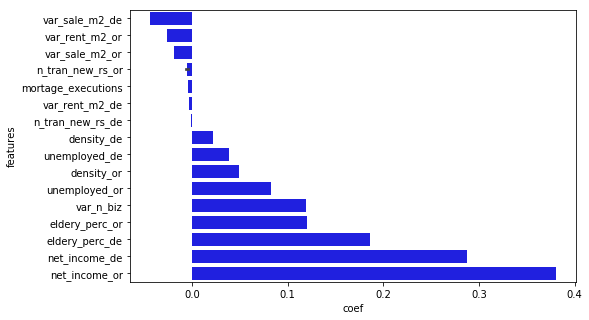

In [32]:
significant_factors_b = summary_b.copy()
significant_factors_b = significant_factors_b.sort_values(by="coef")
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="coef",data=significant_factors_b, color="blue")

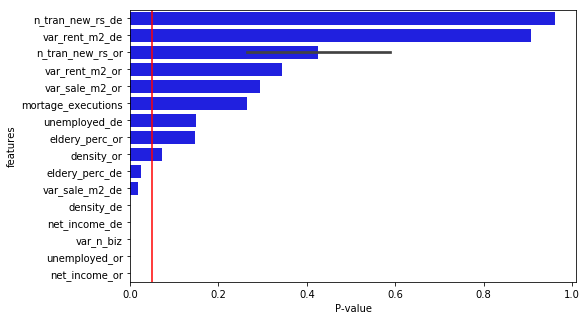

In [33]:
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="P-value",data=summary_b, color="blue")
plt.axvline(x=alpha, color="red")

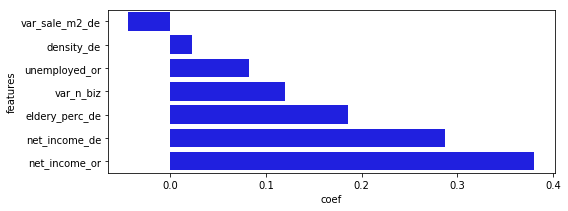

In [34]:
significant_factors_b = summary_b[summary_b["P-value"] < alpha]
significant_factors_b = significant_factors_b.sort_values(by="coef")
plt.figure(figsize=(8, 3))
sns.barplot(y="features",x="coef",data=significant_factors_b, color="blue")

In [35]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test_b, y_pred_b))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test_b, y_pred_b)))

The RMSE in the test data set is: 0.30
 The r2 score in the test data set is: 0.14


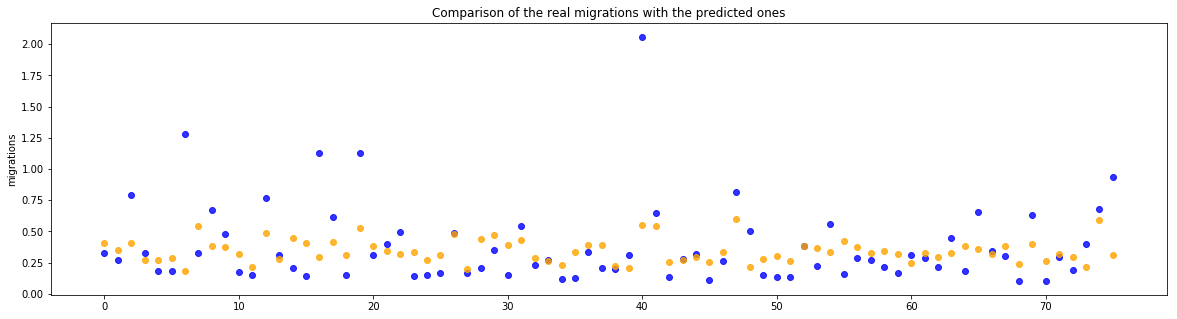

In [36]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test_b)), y=y_test_b, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_b)), y=y_pred_b, fit_reg=False, color="orange")

### Linear model during the crisis 2009-2011

In [37]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_d = feature_vector[feature_vector['period']==2]
feature_columns_ = [x for x in feature_columns if x not in ['period','year','rev_1000_inh_or','var_review_or',
                                                            'rev_1000_inh_de','var_review_de']]

# Split data set: train/test X/Y
info_cols = ["origin","destination","year","migrations"]
info_d = feature_vector_d.loc[:,(info_cols)]

X_train_d, X_test_d, y_train_d, y_test_d = split_train_test_by_quartiles(feature_vector_d, feature_columns_, 
                                                                 target_column, n_splits_dist, labels, train_size)

In [38]:
# Add baseline
X_train_d_ = sm.add_constant(X_train_d.as_matrix())
X_test_d_ = sm.add_constant(X_test_d.as_matrix())

# Train linear regression and predict migrations
mod_d = sm.OLS(exog=X_train_d_, endog=np.array(y_train_d.astype(float))).fit()
y_pred_d = mod_d.predict(np.array(X_test_d_).astype(float))
summary_d = mod_d.summary(xname=feature_columns_)

In [39]:
X_train_d.shape

(1025, 17)

In [40]:
summary_d

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     9.490
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           2.44e-22
Time:                        00:47:11   Log-Likelihood:                 12.364
No. Observations:                1025   AIC:                             9.271
Df Residuals:                    1008   BIC:                             93.12
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
net_income_or          0.3639      0.186      1.955      0.051      -0.001       0.729
density_or             0.0343      0.020      1.725      0.085      -0.005       0.073
unemployed_or          0.0780      0.011      7.185      0.000       0.057       0.099
eldery_perc_or         0.0408      0.030      1.357      0.175      -0.018       0.100
var_sale_m2_or        -0.0227      0.012     -1.857      0.064      -0.047       0.001
var_rent_m2_or         0.0020      0.023      0.087      0.930      -0.043       0.047
n_tran_new_rs_or      -0.0181      0.036     -0.504      0.615      -0.088       0.052
n_tran_new_rs_or      -0.0081      0.005     -1.580      0.114      -0.018       0.002
mortage_executions    -0.0081      0.005     -1.580      0.114      -0.018       0.002
var_n_biz              0.0959      0.161      0.596      0.551      -0.220       0.411
net_income_de          0.1629      0.343      0.476      0.634      -0.509       0.835
unemployed_de          0.0179      0.020      0.894      0.372      -0.021       0.057
eldery_perc_de         0.0379      0.031      1.238      0.216      -0.022       0.098
var_sale_m2_de        -0.0331      0.012     -2.725      0.007      -0.057      -0.009
var_rent_m2_de        -0.0133      0.023     -0.582      0.560      -0.058       0.032
n_tran_new_rs_de      -0.0033      0.036     -0.091      0.928      -0.074       0.067
density_de             0.0514      0.010      5.003      0.000       0.031       0.072
==============================================================================
Omnibus:                      623.847   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6288.480
Skew:                           2.684   Prob(JB):                         0.00
Kurtosis:                      13.883   Cond. No.                     1.18e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.91e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [41]:
pd.read_html(summary_d.tables[1].as_html(), header=0, 
             index_col='Unnamed: 0')[0].to_csv("../feature_extraction/data/results_gls_d_crisis.csv",
                                              index=True, encoding='utf-8')

In [42]:
summary_d = pd.read_csv("../feature_extraction/data/results_gls_d_crisis.csv").rename(columns={'Unnamed: 0':'features'})
summary_d = summary_d.sort_values(by="P>|t|", ascending=False)
summary_d = summary_d.rename(columns={'P>|t|':'P-value'})

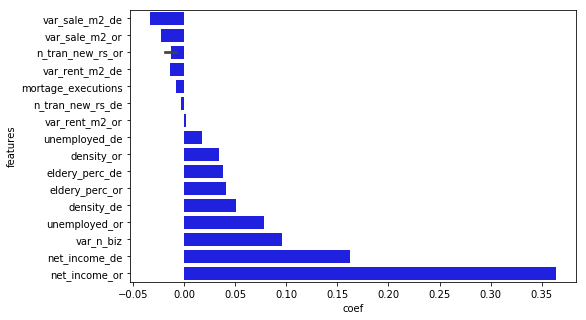

In [43]:
significant_factors_d = summary_d.copy()
significant_factors_d = significant_factors_d.sort_values(by="coef")
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="coef",data=significant_factors_d, color="blue")

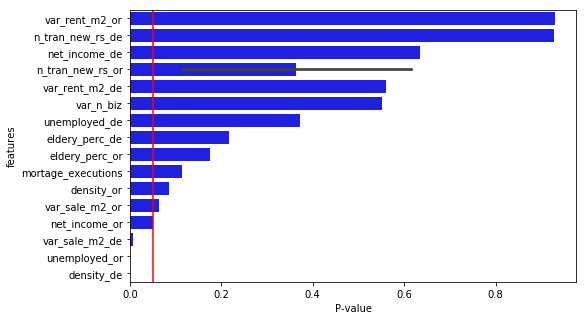

In [44]:
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="P-value",data=summary_d, color="blue")
plt.axvline(x=alpha, color="red")

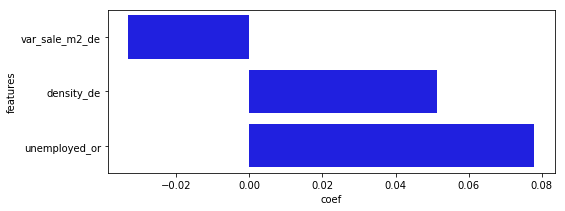

In [45]:
significant_factors_d = summary_d[summary_d["P-value"] < alpha]
significant_factors_d = significant_factors_d.sort_values(by="coef")
plt.figure(figsize=(8, 3))
sns.barplot(y="features",x="coef",data=significant_factors_d, color="blue")

In [46]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test_d, y_pred_d))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test_d, y_pred_d)))

The RMSE in the test data set is: 0.29
 The r2 score in the test data set is: 0.15


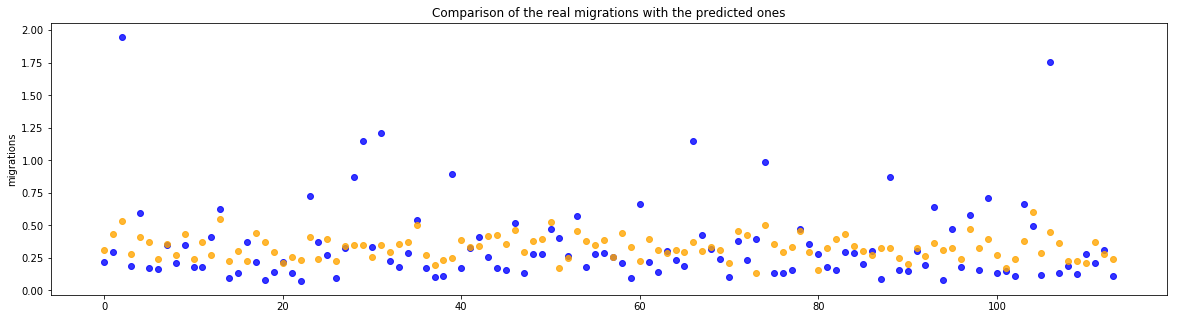

In [47]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test_d)), y=y_test_d, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_d)), y=y_pred_d, fit_reg=False, color="orange")

### Linear model after the european crisis of 2011

In [48]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_a = feature_vector[feature_vector['period']==1]
feature_columns_ = [x for x in feature_columns if x not in ['period','year']]

# Split data set: train/test X/Y
info_cols = ["origin","destination","year","migrations"]
info_a = feature_vector_a.loc[:,(info_cols)]

X_train_a, X_test_a, y_train_a, y_test_a = split_train_test_by_quartiles(feature_vector_a, feature_columns_, 
                                                                 target_column, n_splits_dist, labels, train_size)

In [49]:
# Add baseline
X_train_a_ = sm.add_constant(X_train_a.as_matrix())
X_test_a_ = sm.add_constant(X_test_a.as_matrix())

# Train linear regression and predict migrations
mod_a = sm.OLS(exog=X_train_a_, endog=np.array(y_train_a.astype(float))).fit()
y_pred_a = mod_a.predict(np.array(X_test_a_).astype(float))
summary_a = mod_a.summary(xname=feature_columns_)

In [50]:
X_train_a.shape

(1710, 21)

In [51]:
summary_a

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     11.74
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           7.55e-36
Time:                        00:47:16   Log-Likelihood:                 169.05
No. Observations:                1710   AIC:                            -296.1
Df Residuals:                    1689   BIC:                            -181.8
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
net_income_or          0.2666      0.013     20.030      0.000       0.240       0.293
density_or             0.0314      0.014      2.322      0.020       0.005       0.058
rev_1000_inh_or        0.0677      0.008      8.863      0.000       0.053       0.083
unemployed_or          0.0115      0.005      2.535      0.011       0.003       0.020
eldery_perc_or         0.0264      0.016      1.693      0.091      -0.004       0.057
var_sale_m2_or        -0.0165      0.008     -2.178      0.030      -0.031      -0.002
var_rent_m2_or         0.0065      0.010      0.629      0.529      -0.014       0.027
n_tran_new_rs_or       0.0142      0.014      0.983      0.326      -0.014       0.043
var_review_or          0.0068      0.010      0.676      0.499      -0.013       0.027
n_tran_new_rs_or      -0.0028      0.007     -0.390      0.697      -0.017       0.011
mortage_executions     0.0068      0.010      0.676      0.499      -0.013       0.027
var_n_biz              0.0556      0.029      1.928      0.054      -0.001       0.112
net_income_de          0.0194      0.015      1.303      0.193      -0.010       0.049
rev_1000_inh_de        0.0466      0.014      3.431      0.001       0.020       0.073
var_review_de         -0.0009      0.005     -0.199      0.842      -0.010       0.008
unemployed_de         -0.0003      0.007     -0.038      0.969      -0.014       0.014
eldery_perc_de         0.0504      0.016      3.217      0.001       0.020       0.081
var_sale_m2_de        -0.0279      0.008     -3.671      0.000      -0.043      -0.013
var_rent_m2_de         0.0007      0.010      0.070      0.944      -0.020       0.021
n_tran_new_rs_de       0.0074      0.014      0.512      0.609      -0.021       0.036
density_de             0.0190      0.020      0.959      0.338      -0.020       0.058
==============================================================================
Omnibus:                      829.182   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4617.758
Skew:                           2.274   Prob(JB):                         0.00
Kurtosis:                       9.643   Cond. No.                     1.84e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.8e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [52]:
pd.read_html(summary_a.tables[1].as_html(), header=0, 
             index_col='Unnamed: 0')[0].to_csv("../feature_extraction/data/results_gls_a_crisis.csv",
                                              index=True, encoding='utf-8')

In [53]:
summary_a = pd.read_csv("../feature_extraction/data/results_gls_a_crisis.csv").rename(columns={'Unnamed: 0':'features'})
summary_a = summary_a.sort_values(by="P>|t|", ascending=False)
summary_a = summary_a.rename(columns={'P>|t|':'P-value'})

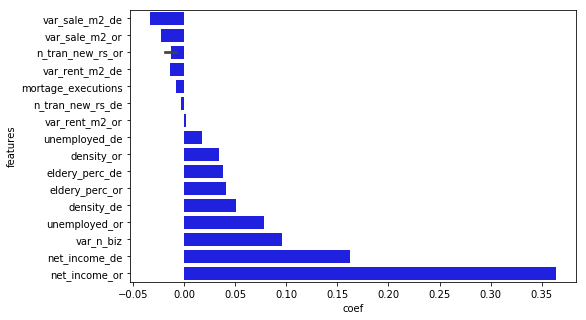

In [54]:
significant_factors_a = summary_d.copy()
significant_factors_a = significant_factors_a.sort_values(by="coef")
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="coef",data=significant_factors_a, color="blue")

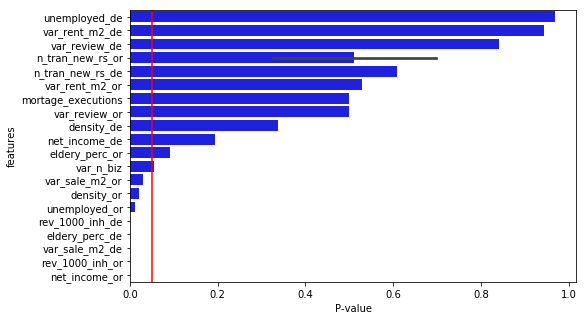

In [55]:
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="P-value",data=summary_a, color="blue")
plt.axvline(x=alpha, color="red")

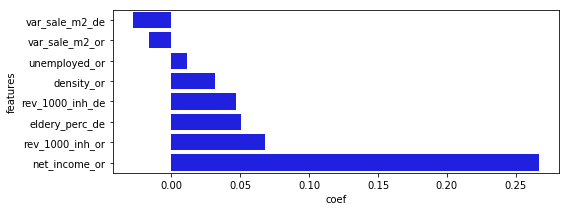

In [56]:
significant_factors_a = summary_a[summary_a["P-value"] < alpha]
significant_factors_a = significant_factors_a.sort_values(by="coef")
plt.figure(figsize=(8, 3))
sns.barplot(y="features",x="coef",data=significant_factors_a, color="blue")

In [57]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test_a, y_pred_a))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test_a, y_pred_a)))

The RMSE in the test data set is: 0.22
 The r2 score in the test data set is: 0.07


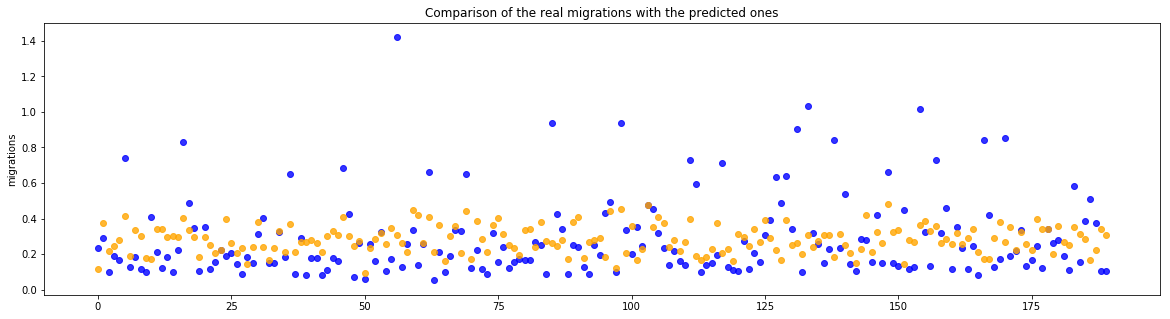

In [58]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test_a)), y=y_test_a, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_a)), y=y_pred_a, fit_reg=False, color="orange")

## Comparison of factors overall and per period

In [59]:
set(significant_factors.features.tolist() + significant_factors_a.features.tolist() + \
              significant_factors_d.features.tolist() + significant_factors_b.features.tolist() + ['period'])

{'density_de',
 'density_or',
 'eldery_perc_de',
 'net_income_de',
 'net_income_or',
 'period',
 'rev_1000_inh_de',
 'rev_1000_inh_or',
 'unemployed_or',
 'var_n_biz',
 'var_sale_m2_de',
 'var_sale_m2_or',
 'year'}

In [60]:
# Define unique existing factors and output structure
factors = set(significant_factors.features.tolist() + significant_factors_a.features.tolist() + \
              significant_factors_d.features.tolist() + significant_factors_b.features.tolist() + ['period'])

factors_ = ['eldery_perc_de', 'density_de','density_or', 'net_income_de', 'net_income_or','unemployed_or', 
            'rev_1000_inh_de', 'rev_1000_inh_or',
            'var_sale_m2_de', 'var_sale_m2_or', 'var_n_biz']

# Assign coeficient values to each period
period_names = ['whole period', 'before_crisis', "between_crisis", "after_crisis"]
periods = [significant_factors, significant_factors_b, significant_factors_d, significant_factors_a]
results = []
for period in range(len(periods)):
    df = periods[period].loc[:,('features','coef')]
    df['period'] = period_names[period]
    results.append(df)
significant_facts = pd.concat(results)
significant_facts["features"] = significant_facts["features"].astype("category", categories=factors_, ordered=True)
significant_facts = significant_facts.dropna()

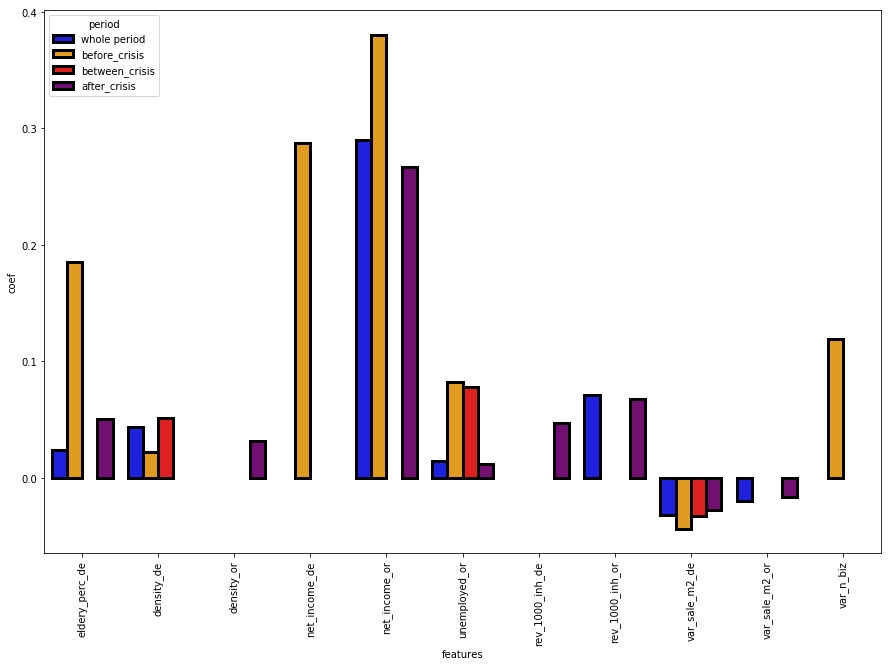

In [61]:
_=plt.figure(figsize=(15, 10))
_=sns.barplot(x='features',y='coef',data=significant_facts, hue='period', palette=['blue','orange','red','purple'],
              linewidth=3, edgecolor='black')
_=plt.xticks(rotation=90)

Text(0.5,1,'2007-2017')

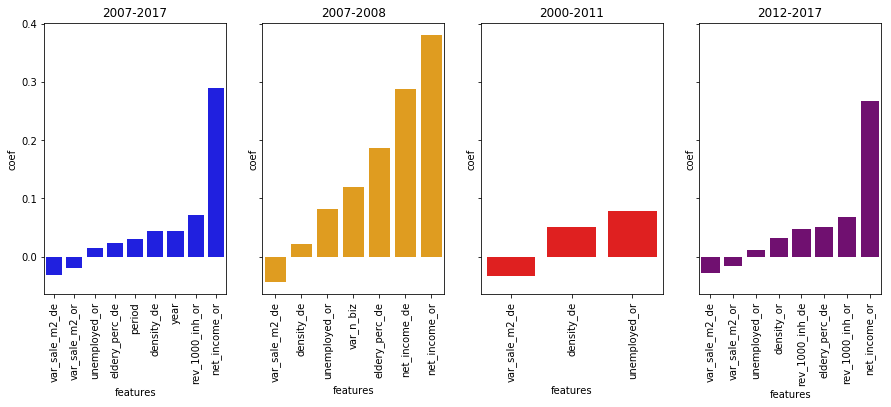

In [62]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(15,5))
sns.barplot(x='features',y='coef',data=significant_factors_b,color='orange',label='before crisis', ax=ax2)
sns.barplot(x='features',y='coef',data=significant_factors_d,color='red',label='during crisis', ax=ax3)
sns.barplot(x='features',y='coef',data=significant_factors_a,color='purple',label='after crisis', ax=ax4)
sns.barplot(x='features',y='coef',data=significant_factors,color='blue',label='after crisis', ax=ax1)
for i,ax in enumerate(f.axes):
    plt.sca(ax)
    plt.xticks(rotation=90)
ax2.set_title("2007-2008")
ax3.set_title("2000-2011")
ax4.set_title("2012-2017")
ax1.set_title("2007-2017")